In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [3]:
users = pd.read_csv('takehome_users.csv', engine='python') #UTF-8 encoding fix
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


**Cleaning**

In [4]:
#be sure creation_time and last_session_creaton_time are both datetime
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit = 's')
#last_session_creation_time is in exponential, need to convert format  #unit = "s"
#convert time_stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [5]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [6]:
users.info()  #datetime successful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [7]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
users.rename(columns = {'object_id':'user_id'}, inplace=True)
#rename object id to be user id

# **Adopted User Identification**

#"adopted user" logged in on three separate days in at least one seven day period.
#identify in the engagement['user_id']
#iterate through every 7 days, 0-6, then 1-7, then 2-8, etc.  

In [9]:
engagement.sort_values(['user_id', 'time_stamp'], inplace=True)

In [10]:
#group by users
engagement_grouped = engagement.groupby('user_id')

In [11]:
engagement_count = pd.DataFrame(engagement['user_id'].value_counts().sort_index())
#get list of user_ids and number of sessions created
engagement_count.head()

,user_id
1,1
2,14
3,1
4,1
5,1


In [12]:
#get a list of the users who have created more than 3 sessions in total
three_plus = engagement_count[engagement_count.user_id >= 3]
user_list = list(three_plus.index)
three_plus.head()

,user_id
2,14
10,284
20,7
33,18
42,342


In [13]:
#3 sessions within 7 days, each on a separate day.  24+ hours apart.

def adopted_user(a):
    #checks that the delta between two timestamps is less than 7 days (1 week)
    #also checks that the delta between any 2 timestamps is more than 1 day
    if (a['shift2'] - a['time_stamp'] <= datetime.timedelta(days=7)) and (a['shift1'] - a['shift2'] >= datetime.timedelta(days=1)) and (a['shift1'] - a['time_stamp'] >= date.timedelta(days=1)):
        return 1
    else:
        return 0


In [14]:
#make a temporary list using three_plus, those that created more than 3 total sessions
temp_list = []

for i in user_list:
    #get the total sessions for the user i
    temp = engagement_grouped.get_group(i)
    
    #shift datetimes up 1 row
    temp['shift1'] = temp.time_stamp.shift(-1)

    #shift datetimes up 2 rows
    temp['shift2'] = temp.time_stamp.shift(-2)
    #if the difference between 'shift' and 'time_stamp' is less than 7 days, give that row a value of 1
    temp['adopted_user'] = temp.apply(adopted_user, axis=1)
    temp_list.append(temp)



/Users/Sandi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Sandi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Sandi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [15]:

#concat the dataframes for each user_id
df = pd.concat(temp_list)


In [16]:
df

,time_stamp,user_id,visited,shift1,shift2,adopted_user
1,2013-11-15 03:45:04,2,1,2013-11-29 03:45:04,2013-12-09 03:45:04,0
2,2013-11-29 03:45:04,2,1,2013-12-09 03:45:04,2013-12-25 03:45:04,0
3,2013-12-09 03:45:04,2,1,2013-12-25 03:45:04,2013-12-31 03:45:04,0
4,2013-12-25 03:45:04,2,1,2013-12-31 03:45:04,2014-01-08 03:45:04,0
5,2013-12-31 03:45:04,2,1,2014-01-08 03:45:04,2014-02-03 03:45:04,0
6,2014-01-08 03:45:04,2,1,2014-02-03 03:45:04,2014-02-08 03:45:04,0
7,2014-02-03 03:45:04,2,1,2014-02-08 03:45:04,2014-02-09 03:45:04,0
8,2014-02-08 03:45:04,2,1,2014-02-09 03:45:04,2014-02-13 03:45:04,0
9,2014-02-09 03:45:04,2,1,2014-02-13 03:45:04,2014-02-16 03:45:04,0
10,2014-02-13 03:45:04,2,1,2014-02-16 03:45:04,2014-03-09 03:45:04,0


Reviewing the columns.  When looking at the adopted_user column, those that are considered Adopted Users, logging in on three separate days in at least one seven day period, are marked as 1.  Otherwise marked as a 0.

In [17]:
#Create list of active users
adopted_user_list = list((df.groupby('user_id').adopted_user.sum() > 0).index)

In [18]:
users['adopted_user'] = users.user_id.apply(lambda x: 1 if x in adopted_user_list else 0)

In [19]:
import matplotlib.pyplot as plt

In [20]:
users.adopted_user.value_counts()

0    9752
1    2248
Name: adopted_user, dtype: int64

There are 2,248 considered Adopted Users.

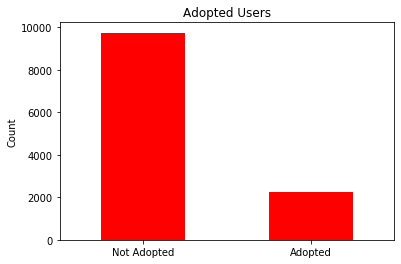

In [21]:
users.adopted_user.value_counts().plot(kind='bar', title='Adopted Users', color= "red")
plt.xticks([0,1], labels=['Not Adopted', 'Adopted'], rotation=None)
plt.ylabel('Count')
plt.show()

# Identify which features predict future user adoption

(sounds like the randomforestclassifier)
https://www.datacamp.com/community/tutorials/random-forests-classifier-python#advantages

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets


**feature engineering first, date time need addressing**

In [23]:
#can convert datetime columns to new columns e.g hour, day etcusers.head(1)
#datetime columns need to be dropped, ['email','creation_time', 'name', 'user_id', 'last_session_creation_time']
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [24]:
users['last_session_creation_month'] = users['last_session_creation_time'].dt.month.head(5)


In [25]:
users['creation_month'] = users['creation_time'].dt.month.head(5)


In [26]:
users['last_session_creation_year'] = users['last_session_creation_time'].dt.year.head(5)

In [27]:
users['creation_year'] = users['creation_time'].dt.year.head(5)

In [28]:
users['last_session_creation_day'] = users['last_session_creation_time'].dt.day.head(5)

In [29]:
users['creation_day'] = users['creation_time'].dt.day.head(5)

In [30]:
users.head(5)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,last_session_creation_month,creation_month,last_session_creation_year,creation_year,last_session_creation_day,creation_day
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,4.0,4.0,2014.0,2014.0,22.0,22.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,3.0,11.0,2014.0,2013.0,31.0,15.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,3.0,3.0,2013.0,2013.0,19.0,19.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,5.0,5.0,2013.0,2013.0,22.0,21.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0,1.0,2013.0,2013.0,22.0,17.0


In [35]:
users_clean = users.drop(['email','creation_time', 'name', 'user_id', 'last_session_creation_time'], axis = 1)

In [46]:
#convert other categorical columns into dummies
X = pd.get_dummies(users_clean, drop_first=True) 

In [47]:
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,last_session_creation_month,creation_month,last_session_creation_year,creation_year,last_session_creation_day,creation_day,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,4.0,4.0,2014.0,2014.0,22.0,22.0,0,0,0,0
1,0,0,1,316.0,1,3.0,11.0,2014.0,2013.0,31.0,15.0,1,0,0,0
2,0,0,94,1525.0,0,3.0,3.0,2013.0,2013.0,19.0,19.0,1,0,0,0
3,0,0,1,5151.0,0,5.0,5.0,2013.0,2013.0,22.0,21.0,0,0,0,0
4,0,0,193,5240.0,0,1.0,1.0,2013.0,2013.0,22.0,17.0,0,0,0,0
5,0,0,197,11241.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
6,0,1,37,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
7,1,1,74,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
8,0,0,302,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
9,1,1,318,4143.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0


In [33]:
#https://www.datacamp.com/community/tutorials/random-forests-classifier-python#advantages

In [48]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#X=users_clean  # Features
y=users['adopted_user']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training 

In [49]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))